# Sequential Monte Carlo

#### Sequential Monte Carlo with fixed geometric path

In [89]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import math
import numpy as np

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.smc.geometric_smc import GeometricSMC
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student
from mcjax.proba.banana2d import Banana2D
from mcjax.proba.log_gauss_pines import LogGaussPines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# initialize jax RNG
key = jr.key(0)

In [91]:
# Define the initial and target distribution
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)
# log_gamma_T = NealFunnel()

mu_1 = jnp.ones(dim)
sigma_1 = 2.
log_var_1 = jnp.log(sigma_1**2)
log_gamma_T = IsotropicGauss(mu=mu_1, log_var=log_var_1)

# Define the SMC method
N = 10
coefs = jnp.arange(N+1)/N
step_size = 1.2
num_substeps = 5
num_particles = 10_000
key, key_ = jr.split(key)
mc_method = "MALA"

GSMC = GeometricSMC(log_gamma_0=log_gamma_0,log_gamma_T=log_gamma_T,coefs=coefs,\
                     step_size=step_size,num_substeps=num_substeps)
GSMC_run = jax.jit(GSMC.run, static_argnums=(0,2))


In [92]:
particles_arr, _, step_size_arr, acc_size_arr = GSMC_run(num_particles=num_particles,key=key_,mc_method=mc_method)

C:\Users\Hangao Liang\AppData\Local\Temp\ipykernel_25692\3610375860.py:19: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  axes[i, j].contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')


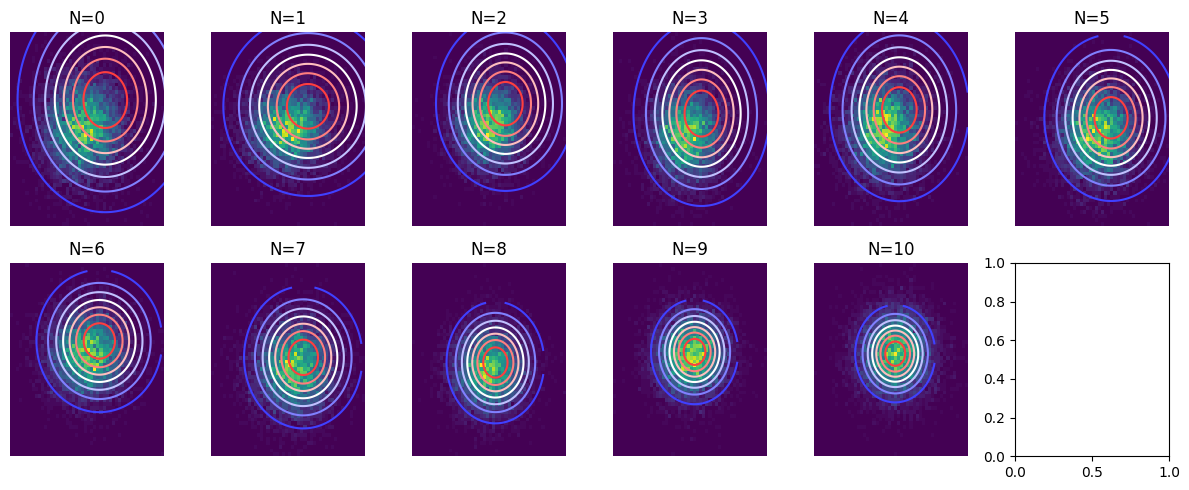

In [93]:
# Draw the intermediate distributions
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N_discr = 500
X, Y = jnp.meshgrid(jnp.linspace(xmin, xmax, N_discr), jnp.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_T = jnp.exp(log_gamma_T.batch(jnp.array([X_flat, Y_flat]).T)).reshape(X.shape)

nrows = 2
ncols = math.ceil((N+1)/nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

# Loop over the axes to plot something
for i in range(nrows):
    for j in range(ncols):
        if (i == nrows-1 and j == ncols-1):
            break
        axes[i, j].contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')
        particles = particles_arr[:,:,i*6+j]
        axes[i, j].hist2d(particles[:,0], particles[:,1], bins=50, cmap='viridis', density=True)
        axes[i, j].set_axis_off()
        axes[i, j].set_title(f"N={i*6+j}")  

plt.tight_layout()  


#### Variation of step size

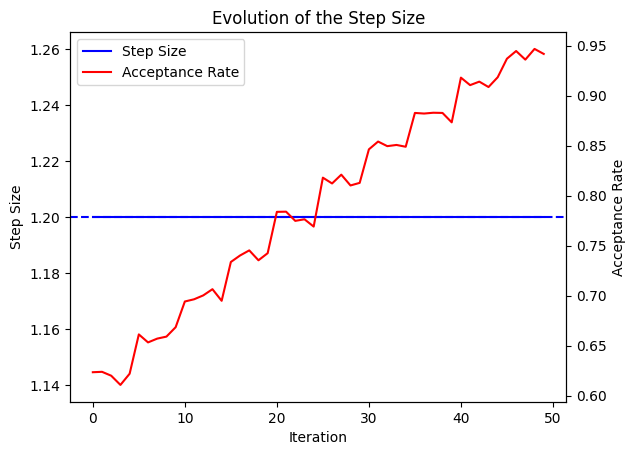

In [94]:
fig, ax1 = plt.subplots()

# Plot step size on the left y-axis
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Step Size')
line1, = ax1.plot(step_size_arr.flatten(order='F'), label='Step Size', color='b')
ax1.tick_params(axis='y')
ax1.axhline(step_size, color='b', linestyle='--', label='Initial Step Size')

# Create a second y-axis for acceptance rate
ax2 = ax1.twinx()  
ax2.set_ylabel('Acceptance Rate')
line2, = ax2.plot(acc_size_arr.flatten(order='F'), label='Acceptance Rate', color='r')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Evolution of the Step Size')
# plt.xlim(0,20)
plt.show()

### Adaptive Temperature

In [95]:
# Define the initial and target distributions   
dim = 2
mu_0 = jnp.ones(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)

# log_gamma_T = NealFunnel()

mu_1 = jnp.zeros(dim)
sigma_1 = 0.5
log_var_1 = jnp.log(sigma_1**2)
log_gamma_T = IsotropicGauss(mu=mu_1, log_var=log_var_1)

# log_gamma_T = Banana2D()    


# Setting up the parameters for the self-adaptive run
num_particles = 10_000
N = 10
coefs = jnp.arange(N+1)/N
key, key_ = jr.split(key)
mc_method = "MALA"
step_size = 2.
num_substeps = 5
GSMC = GeometricSMC(log_gamma_0=log_gamma_0,log_gamma_T=log_gamma_T,coefs=coefs,\
                     step_size=step_size,num_substeps=num_substeps)
GSMC_adaptiverun = jax.jit(GSMC.selfadaptive_run, static_argnums=(0,2))


In [96]:
# Run the self-adaptive run
t, particles_arr, _, step_size_arr, acc_rate_arr, coefs = GSMC_adaptiverun(num_particles=num_particles,key=key_,mc_method=mc_method)
# Slice the arrays to only include the iterations performed.
particles_arr = particles_arr[:, :, :t]
step_size_arr = step_size_arr[:, :t - 1]
acc_rate_arr  = acc_rate_arr[:, :t - 1]
coefs = coefs[:t]
GSMC.coefs = coefs

C:\Users\Hangao Liang\AppData\Local\Temp\ipykernel_25692\4142071829.py:20: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  axes[i, j].contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')


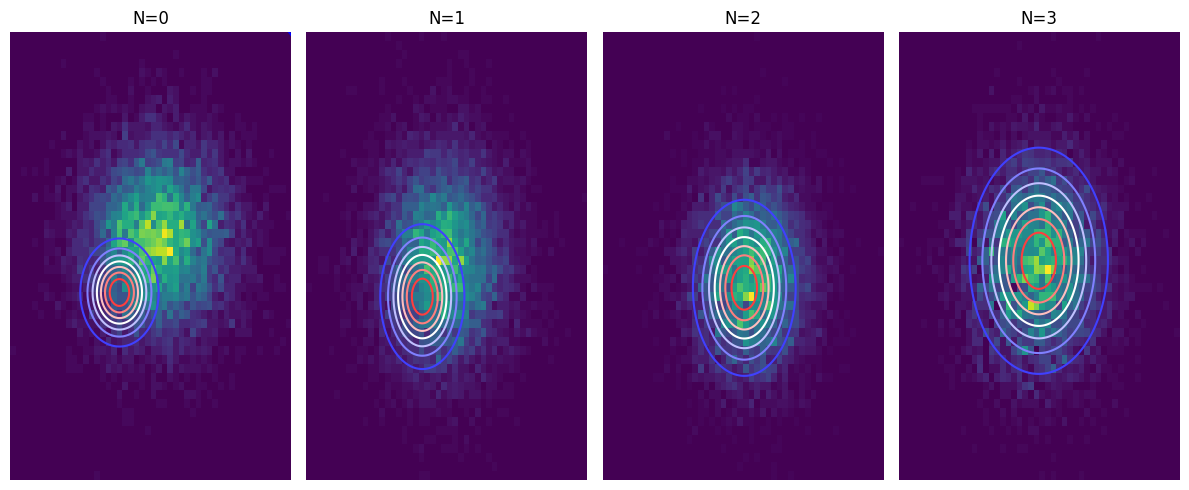

In [97]:
# Draw the intermediate distributions
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N_discr = 500
X, Y = jnp.meshgrid(jnp.linspace(xmin, xmax, N_discr), jnp.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_T = jnp.exp(log_gamma_T.batch(jnp.array([X_flat, Y_flat]).T)).reshape(X.shape)

ncols = np.min([5, len(GSMC.coefs)])
nrows = math.ceil(len(GSMC.coefs)/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))
axes = np.atleast_2d(axes)

# Loop over the axes to plot something
for i in range(nrows):
    for j in range(ncols):
        if i*ncols + j >= len(GSMC.coefs):
            break
        axes[i, j].contour(X, Y, Z_T,color = 'b',label="Final(Theoritical)",cmap='bwr', origin='lower')
        particles = particles_arr[:,:,i*ncols+j]
        axes[i, j].hist2d(particles[:,0], particles[:,1], bins=50, cmap='viridis', density=True)
        axes[i, j].set_axis_off()
        axes[i, j].set_title(f"N={i*ncols+j}")  

plt.tight_layout()  


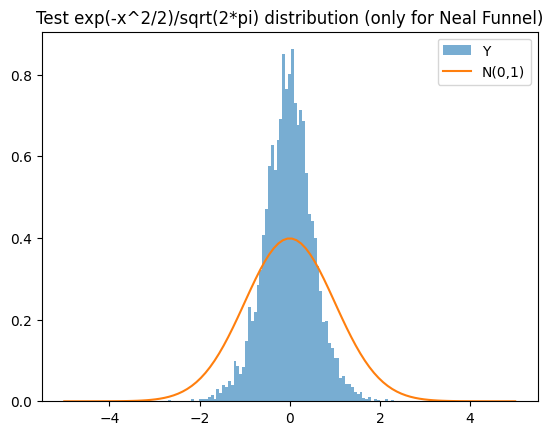

In [98]:
plt.figure()
plt.hist(particles[:,1]*jnp.exp(-particles[:,0]/2), bins="auto", density=True, alpha=0.6, label='Y')
X = jnp.linspace(-5,5,100)  
plt.plot(X,jnp.exp(-X**2/2)/jnp.sqrt(2*jnp.pi),label="N(0,1)")
plt.title("Test exp(-x^2/2)/sqrt(2*pi) distribution (only for Neal Funnel)")
plt.legend()


#### Variation of temperature in the geometric path

[0.         0.19765472 0.5970521  1.        ]


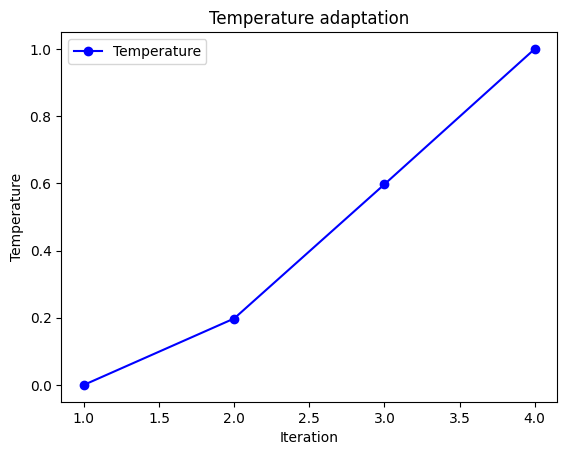

In [99]:
temperature_adapted = GSMC.coefs
plt.plot(jnp.arange(1,len(temperature_adapted)+1),temperature_adapted, label='Temperature', color='b', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.legend()    
plt.title('Temperature adaptation')
print(temperature_adapted)


#### Variation of step size

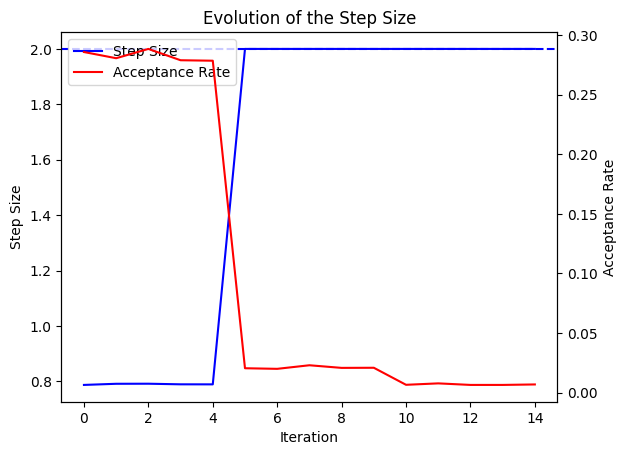

In [100]:
fig, ax1 = plt.subplots()

# Plot step size on the left y-axis
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Step Size')
line1, = ax1.plot(step_size_arr.flatten(order='F'), label='Step Size', color='b')
ax1.tick_params(axis='y')
ax1.axhline(step_size, color='b', linestyle='--', label='Initial Step Size')

# Create a second y-axis for acceptance rate
ax2 = ax1.twinx()  
ax2.set_ylabel('Acceptance Rate')


line2, = ax2.plot(acc_rate_arr.flatten(order='F'), label='Acceptance Rate', color='r')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Evolution of the Step Size')
# plt.xlim(0,20)
plt.show()